=========num_train: 1000
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
num_feature
2
self.X_norm
[[0. 0.]
 [0. 0.]]
col_i
min
max-min
new_col
col_i
min
max-min
new_col
X_new
[[0.40330596 0.25316456]
 [0.67447738 0.43037975]
 [0.83415961 0.07594937]
 ...
 [0.49428442 0.2278481 ]
 [0.22356386 0.46835443]
 [0.57111043 0.29113924]]
self.params.batch_size:
10
max_iteration:
100
checkpoint_iteration:
10


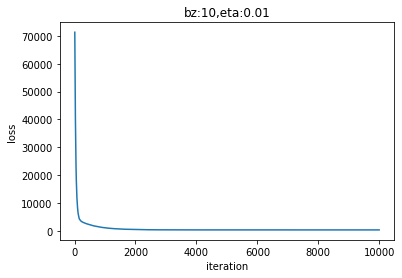

W= [[-40.09257348]
 [399.45209676]]
B= [[244.9135708]]
[15 93]
[[15 93]]
[[0.65060977 0.67088608]]
Z= [[486.81580033]]


In [94]:

import numpy as np
from pathlib import Path
from enum import Enum
import math
import matplotlib.pyplot as plt



class SimpleDataReader(object):
    def __init__(self):
        self.train_file_name = "ch05.npz"
        self.num_train = 0
        self.XTrain = None  
        self.YTrain = None  
        self.XRaw = None    
        self.YRaw = None    


    def ReadData(self):
        train_file = Path(self.train_file_name)
        if train_file.exists():
            data = np.load(self.train_file_name)
            self.XRaw = data["data"]
#             print(self.XRaw)
            self.YRaw = data["label"]
#             print(self.YRaw)
            self.num_train = self.XRaw.shape[0]
            print("=========num_train:",self.num_train)
            self.XTrain = self.XRaw
            self.YTrain = self.YRaw
        else:
            raise Exception("找不到训练数据文件")
            
    def NormalizeX(self):
        # 申请全0矩阵
        X_new = np.zeros(self.XRaw.shape)
        print(X_new)
        # 2列-x,y
        num_feature = self.XRaw.shape[1]
        print("num_feature")
        print(num_feature)
        self.X_norm = np.zeros((num_feature,2))
        print("self.X_norm")
        print(self.X_norm)
        
        for i in range(num_feature):

            col_i = self.XRaw[:,i]
            print("col_i")
#             print(col_i)
            max_value = np.max(col_i)
            min_value = np.min(col_i)
            # min value
            self.X_norm[i,0] = min_value 
            print("min")
#             print(self.X_norm[i,0])
            # range value
            self.X_norm[i,1] = max_value - min_value 
            print("max-min")
#             print(self.X_norm[i,1])
            new_col = (col_i - self.X_norm[i,0])/(self.X_norm[i,1])
            print("new_col")
#             print(new_col)
            X_new[:,i] = new_col
           
        #end for
        self.XTrain = X_new
        print("X_new")
        print(X_new)
    
    #打乱数据
    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP
        
    #按批次得到训练数据
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y
    
    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain
    
    
    def NormalizePredicateData(self, X_raw):
        X_new = np.zeros(X_raw.shape)
        n = X_raw.shape[1]
        for i in range(n):
            col_i = X_raw[:,i]
            X_new[:,i] = (col_i - self.X_norm[i,0]) / self.X_norm[i,1]
        return X_new
        

        #  to here
class HyperParameters(object):
    def __init__(self, input_size, output_size, eta=0.1, max_epoch=1000, batch_size=5, eps=0.1):
        self.input_size = input_size
        self.output_size = output_size
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps

    def toString(self):
        title = str.format("bz:{0},eta:{1}", self.batch_size, self.eta)
        return title


class NeuralNet(object):
    def __init__(self, params):
        self.params = params
        self.W = np.zeros((self.params.input_size, self.params.output_size))
        self.B = np.zeros((1, self.params.output_size))

    def __forwardBatch(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        return Z

    def __backwardBatch(self, batch_x, batch_y, batch_z):
        m = batch_x.shape[0]
        dZ = batch_z - batch_y
        dB = dZ.sum(axis=0, keepdims=True)/m
        dW = np.dot(batch_x.T, dZ)/m
        return dW, dB

    def __update(self, dW, dB):
        self.W = self.W - self.params.eta * dW
        self.B = self.B - self.params.eta * dB

    def inference(self, x):
        return self.__forwardBatch(x)

    def train(self, dataReader, checkpoint=0.1):
        loss_history = TrainingHistory()
        loss = 10
        if self.params.batch_size == -1:
            self.params.batch_size = dataReader.num_train
            
        print("self.params.batch_size:")    
        print(self.params.batch_size)
        
        max_iteration = math.ceil(dataReader.num_train / self.params.batch_size)
        print("max_iteration:")
        print(max_iteration)
        checkpoint_iteration = (int)(max_iteration * checkpoint)
        print("checkpoint_iteration:")
        print(checkpoint_iteration)
        
        for epoch in range(self.params.max_epoch):
#             print("epoch=%d" %epoch)
            dataReader.Shuffle()
            for iteration in range(max_iteration):
                # get x and y value for one sample
                batch_x, batch_y = dataReader.GetBatchTrainSamples(self.params.batch_size, iteration)
                # 代入公式
                batch_z = self.__forwardBatch(batch_x)
                # 反向传播
                dW, dB = self.__backwardBatch(batch_x, batch_y, batch_z)
                # update w,b
                self.__update(dW, dB)

                total_iteration = epoch * max_iteration + iteration
                if (total_iteration+1) % checkpoint_iteration == 0:
                    loss = self.__checkLoss(dataReader)
#                     print("epoch, iteration, loss, self.W, self.B")
#                     print(epoch, iteration, loss, self.W, self.B)
                    loss_history.AddLossHistory(epoch*max_iteration+iteration, loss)
                    if loss < self.params.eps:
                        break
            
            if loss < self.params.eps:
                break
     
        loss_history.ShowLossHistory(self.params)
        print("W=", self.W)
        print("B=", self.B)

    #损失函数
    def __checkLoss(self, dataReader):
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = self.__forwardBatch(X)
        LOSS = (Z - Y)**2
        loss = LOSS.sum()/m/2
        return loss

class TrainingHistory(object):
    def __init__(self):
        self.iteration = []
        self.loss_history = []
        self.w_history = []
        self.b_history = []

    def AddLossHistory(self, iteration, loss):
        self.iteration.append(iteration)
        self.loss_history.append(loss)


    # 画图
    def ShowLossHistory(self, params, xmin=None, xmax=None, ymin=None, ymax=None):
        plt.plot(self.iteration, self.loss_history)
        title = params.toString()
        plt.title(title)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        if xmin != None and ymin != None:
            plt.axis([xmin, xmax, ymin, ymax])
        plt.show()
        return title

    def GetLast(self):
        count = len(self.loss_history)
        return self.loss_history[count-1], self.w_history[count-1], self.b_history[count-1]
# end class

if __name__ == '__main__':
#     a=[[1,0,5,6,7,8],
#        [1,0,5,6,7,8],
#        [1,0,5,6,7,8]]
#     a=np.array(a)
#     print(a[1,1:2])
    #data
    reader = SimpleDataReader()
    reader.ReadData()
    reader.NormalizeX()
    # net
    params = HyperParameters(2, 1, eta=0.01, max_epoch=100, batch_size=10, eps = 1e-5)
    net = NeuralNet(params)
    net.train(reader, checkpoint=0.1)
    # inference
    x1 = 15
    x2 = 93
    x = np.array([x1,x2])
    print(x)
    x = np.array([x1,x2]).reshape(1,2)
    print(x)
    # 传入数据归一化
    x_new = reader.NormalizePredicateData(x)
    print(x_new)
    z = net.inference(x_new)
    print("Z=", z)

